# Meta Models

Certain models in scikit-lego are "meta". Meta models are
models that depend on other estimators that go in and these
models will add features to the input model. One way of thinking
of a meta model is to consider it to be a way to "decorate" a
model.

This part of the documentation will highlight a few of them.

## Thresholder

The thresholder can help tweak recall and precision of a model
by moving the threshold value of `predict_proba`. Commonly this
threshold is set at 0.5 for two classes. This meta-model can
decorate an estimator with two classes such that the threshold
moves.

We demonstrate the working below. First we'll generate a skewed dataset.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder

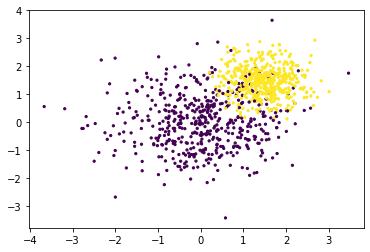

In [2]:
X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

Next we'll make a cross validation pipeline to try out this thresholder.

In [10]:
%%time 

pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                   param_grid = {"model__threshold": np.linspace(0.1, 0.9, 500)},
                   scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                   refit="precision",
                   cv=5)

_ = mod.fit(X, y)

CPU times: user 12.4 s, sys: 0 ns, total: 12.4 s
Wall time: 12.3 s


With this cross validation trained, we'll make a chart to show the
effect of changing the threshold value.

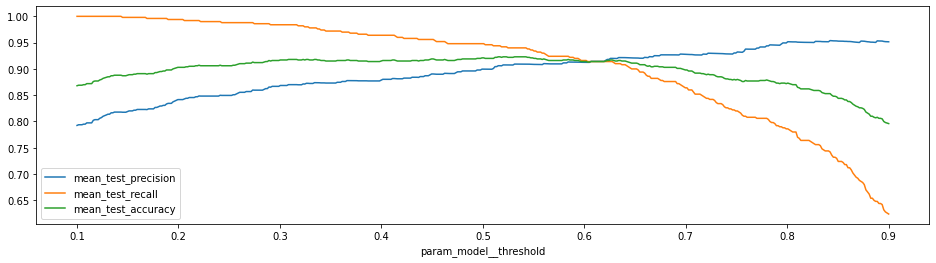

In [11]:
(pd.DataFrame(mod.cv_results_)
 .set_index("param_model__threshold")
 [['mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']]
 .plot(figsize=(16, 4)));

Increasing the threshold will increase the precision but as expected this is at the
cost of recall (and accuracy).

### Saving Compute 

Technically, you may not need to refit the underlying model that the `Thresholder` model wraps around. In those situations you can set the `refit` paramater to `False`. If you've got a predefined single model and you're only interested in tuning the cutoff this might make everything run a whole lot faster.


In [12]:
%%time 

# Train an original model 
orig_model = LogisticRegression(solver='lbfgs')
orig_model.fit(X, y)

# Ensure that refit=False
pipe = Pipeline([
    ("model", Thresholder(orig_model, threshold=0.1, refit=False))
])

# This should now be a fair bit quicker.
mod = GridSearchCV(estimator=pipe,
                   param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                   scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                   refit="precision",
                   cv=5)

_ = mod.fit(X, y);

CPU times: user 1.21 s, sys: 0 ns, total: 1.21 s
Wall time: 1.21 s


## Grouped Prediction

<img src="_static/grouped-model.png" width="50%" alt="img1">

To help explain what it can do we'll consider three methods to predict
the chicken weight. The chicken data has 578 rows and 4 columns
from an experiment on the effect of diet on early growth of chicks.
The body weights of the chicks were measured at birth and every second
day thereafter until day 20. They were also measured on day 21.
There were four groups on chicks on different protein diets.

### Setup

Let's first load a bunch of things to do this.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

This code will be used to explain the steps below.

### Model 1: Linear Regression with Dummies

First we start with a baseline.

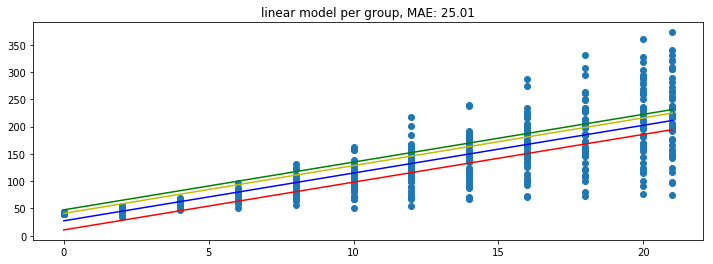

In [6]:
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
         ("discrete", Pipeline([
             ("grab", ColumnSelector("diet")),
             ("encode", OneHotEncoder(categories="auto", sparse=False))
         ])),
         ("continuous", Pipeline([
             ("grab", ColumnSelector("time")),
             ("standardize", StandardScaler())
         ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)

Because the model is linear the dummy variable causes the intercept
to change but leaves the gradient untouched. This might not be what
we want from a model. So let's see how the grouped model can address
this.

### Model 2: Linear Regression in GroupedEstimation

The goal of the grouped estimator is to allow us to split up our data.
The image below demonstrates what will happen.

<img src="_static/grouped-df.png" width="70%" alt="img2">

We train 5 models in total because the model will also train a
fallback automatically (you can turn this off via `use_fallback=False`).
The idea behind the fallback is that we can predict something if
the group does not appear in the prediction.

Each model will accept features that are in `X` that are not
part of the grouping variables. In this case each group will
model based on the `time` since `weight` is what we're trying
to predict.

Applying this model to the dataframe is easy.

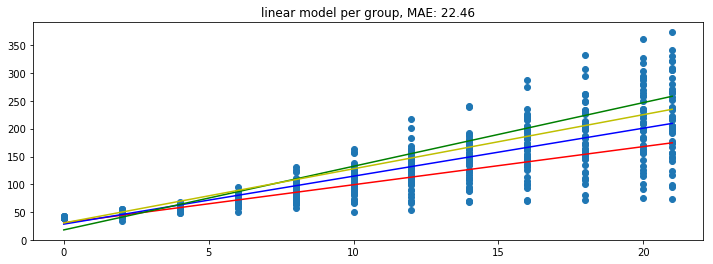

In [7]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=["diet"])
plot_model(mod)

And the model looks a bit better.

### Model 3: Dummy Regression in GroupedEstimation

We could go a step further and train a [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) per diet
per timestep. The code below works similar as the previous example
but one difference is that the grouped model does not receive a
dataframe but a numpy array.

<img src="_static/grouped-np.png" width="70%" alt="img3">

Note that we're also grouping over more than one column here.
The code that does this is listed below.

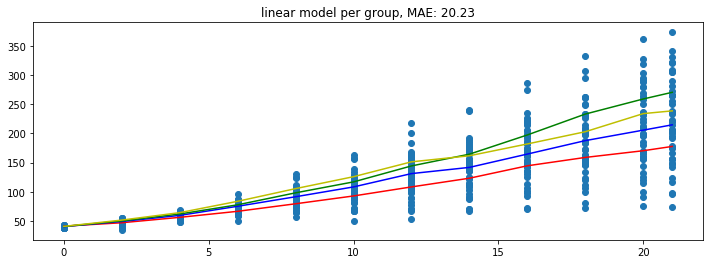

In [8]:
from sklearn.dummy import DummyRegressor

feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
         ("discrete", Pipeline([
             ("grab", ColumnSelector("diet")),
         ])),
         ("continuous", Pipeline([
             ("grab", ColumnSelector("time")),
         ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", GroupedPredictor(DummyRegressor(strategy="mean"), groups=[0, 1]))
])

plot_model(pipe)

Note that these predictions seems to yield the lowest error but take it
with a grain of salt since these errors are only based on the train set.

## Grouped Transformation

We can apply grouped prediction on estimators that have a `.predict()` implemented but we're also able to do something similar for transfromers, like `StandardScaler`. 



In [49]:
from sklego.datasets import load_penguins

df_peng = (load_penguins(as_frame=True)
           .dropna()
           .drop(columns=['island', 'bill_depth_mm', 'bill_length_mm']))
df_peng.head()

,species,flipper_length_mm,body_mass_g,sex
0,Adelie,181.0,3750.0,male
1,Adelie,186.0,3800.0,female
2,Adelie,195.0,3250.0,female
4,Adelie,193.0,3450.0,female
5,Adelie,190.0,3650.0,male


Let's say that we're interested in scaling the numeric data in this dataframe. If we apply a normal `StandardScaler` then we'll likely get clusters appear for all the `species` and for the `sex`. It may be the case (for fairness reasons) that we don't mind the clusters based on `species` but that we *do* mind the clusters based on `sex`. In these scenarios the `GroupedTransformer` can help out. We can specify a grouping column that the data needs to be split on before the transformation is applied.

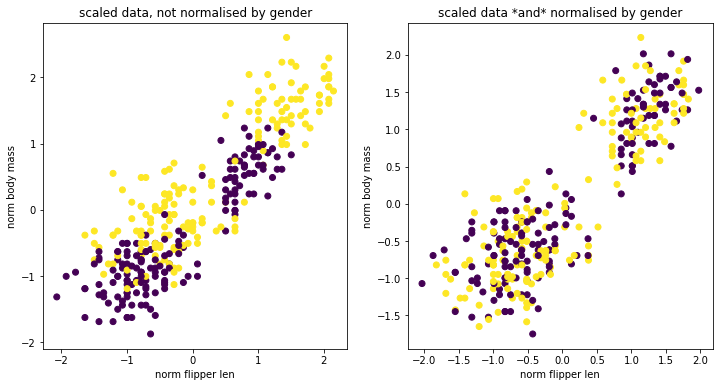

In [50]:
from sklearn.preprocessing import StandardScaler
from sklego.meta import GroupedTransformer

plt.figure(figsize=(12, 6))
# we'll drop species because we're not grouping on it
df_peng = df_peng.drop(columns=["species"])

plt.subplot(121)
X     = df_peng.drop(columns=['sex']).values
X_tfm = StandardScaler().fit_transform(X)
plt.scatter(X_tfm[:, 0], X_tfm[:, 1], c=df_peng['sex'] == 'male')
plt.xlabel("norm flipper len")
plt.ylabel("norm body mass")
plt.title("scaled data, not normalised by gender")

plt.subplot(122)
X_tfm = GroupedTransformer(StandardScaler(), groups=['sex']).fit_transform(df_peng)
plt.scatter(X_tfm[:, 0], X_tfm[:, 1], c=df_peng['sex'] == 'male')
plt.xlabel("norm flipper len")
plt.ylabel("norm body mass")
plt.title("scaled data *and* normalised by gender");

You can see that there are certainly still clusters. These are caused by the fact that there's different `species` of penguin in our dataset. However you can see that when we apply our `GroupedTransformer` that we're suddenly able to normalise towards `sex` as well. 

#### Other Scenarios 

This transformer also has use-cases beyond fairness. You could use this transformer to causally compensate for subgroups in your data. For example, for predicting house prices, using the surface of a house relatively to houses in the same neighborhood could be a more relevant feature than the surface relative to all houses. 

## Decayed Estimation

Often you are interested in predicting the future. You use the data from
the past in an attempt to achieve this and it could be said that perhaps
data from the far history is less relevant than data from the recent past.

This is the idea behind the `DecayEstimator` meta-model. It looks at the
order of data going in and it will assign a higher importance to recent rows
that occurred recently and a lower importance to older rows. Recency is based
on the order so it is imporant that the dataset that you pass in is correctly
ordered beforehand.

We'll demonstrate how it works by applying it on a simulated timeseries problem.


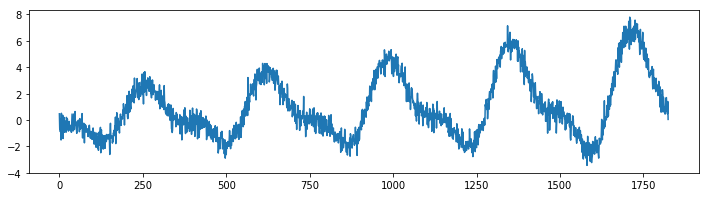

In [9]:
from sklearn.dummy import DummyRegressor
from sklego.meta import GroupedEstimator, DecayEstimator
from sklego.datasets import make_simpleseries

yt = make_simpleseries(seed=1)
df = (pd.DataFrame({"yt": yt,
                   "date": pd.date_range("2000-01-01", periods=len(yt))})
      .assign(m=lambda d: d.date.dt.month)
      .reset_index())

plt.figure(figsize=(12, 3))
plt.plot(make_simpleseries(seed=1));

We will create two models on this dataset. One model calculates the average
value per month in our timeseries and the other does the same thing but will
decay the importance of making accurate predictions for the far history.


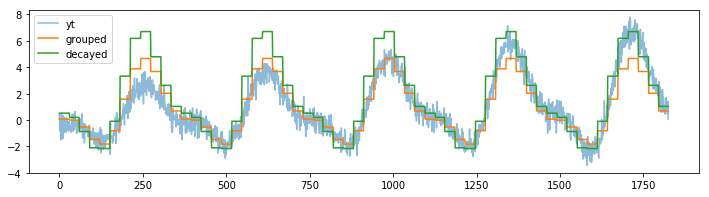

In [10]:
mod1 = (GroupedEstimator(DummyRegressor(), groups=["m"])
        .fit(df[['m']], df['yt']))


mod2 = (GroupedEstimator(DecayEstimator(DummyRegressor(), decay=0.9), groups=["m"])
        .fit(df[['index', 'm']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.plot(mod2.predict(df[['index', 'm']]), label="decayed")
plt.legend();

The decay parameter has a lot of influence on the effect of the model but one
can clearly see that we shift focus to the more recent data.

## Confusion Balancer 

**Disclaimer**: This is an experimental feature. 

We added an experimental feature to the meta estimators that can be used to force balance in the confusion matrix of an estimator. The approach works 

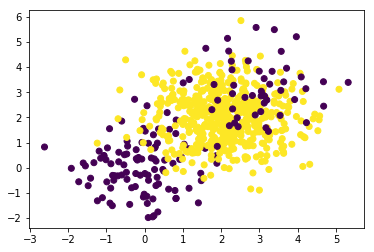

In [11]:
n1, n2, n3 = 100, 500, 50
np.random.seed(42)
X = np.concatenate([np.random.normal(0, 1, (n1, 2)), 
                    np.random.normal(2, 1, (n2, 2)),
                    np.random.normal(3, 1, (n3, 2))], 
                   axis=0)
y = np.concatenate([np.zeros((n1, 1)), 
                    np.ones((n2, 1)),
                    np.zeros((n3, 1))], 
                   axis=0).reshape(-1)
plt.scatter(X[:, 0], X[:, 1], c=y);

Let's take this dataset and train a simple classifier against it.

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
mod = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
cfm = confusion_matrix(y, mod.fit(X, y).predict(X))
cfm

array([[ 72,  78],
       [  4, 496]])

The confusion matrix is not ideal. This is in part because the dataset is slightly imbalanced but in general it is also because of the way the algorithm works. Let's see if we can learn something else from this confusion matrix. I might transform the counts into probabilities.

In [14]:
cfm.T / cfm.T.sum(axis=1).reshape(-1, 1)

array([[0.94736842, 0.05263158],
       [0.1358885 , 0.8641115 ]])

Let's consider the number 0.2346 in the lower left corner. This number represents the probability that the actually class 0 while the model predicts class 1. In math we might write this as $P(C_1 | M_1)$ where $C_i$ denotes the actual label while $M_i$ denotes the label given by the algorithm. 

The idea now is that we might rebalance our original predictions $P(M_i)$ by multiplying them;

$$ P_{\text{corrected}}(C_1) = P(C_1|M_0) p(M_0) + P(C_1|M_1) p(M_1) $$ 

In general this can be written as; 

$$ P_{\text{corrected}}(C_i) = \sum_j P(C_i|M_j) p(M_j) $$

In laymens terms; we might be able to use the confusion matrix to learn from our mistakes. By how much we correct is something that we can tune with a hyperparameter. 

$$ P_{\text{corrected}}(C_i) = \alpha \sum_j P(C_i|M_j) p(M_j) + (1-\alpha) p(M_j) $$

We'll perform an optimistic demonstration below.

In [15]:
def false_positives(mod, x, y):
    return (mod.predict(x) != y)[y == 1].sum()

def false_negatives(mod, x, y):
    return (mod.predict(x) != y)[y == 0].sum()

In [16]:
from sklego.meta import ConfusionBalancer

In [17]:
cf_mod = ConfusionBalancer(LogisticRegression(solver='lbfgs', max_iter=1000), alpha=1.0)

grid = GridSearchCV(cf_mod, 
                    param_grid={'alpha': np.linspace(-1.0, 3.0, 31)},
                    scoring={
                        "accuracy": make_scorer(accuracy_score),
                        "positives": false_positives,
                        "negatives": false_negatives
                    },
                    n_jobs=-1,
                    iid=True,
                    return_train_score=True,
                    refit="negatives",
                    cv=5)

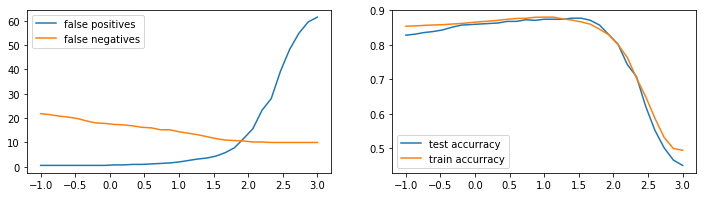

In [18]:
df = pd.DataFrame(grid.fit(X, y).cv_results_)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(df['param_alpha'], df['mean_test_positives'], label="false positives")
plt.plot(df['param_alpha'], df['mean_test_negatives'], label="false negatives")
plt.legend()
plt.subplot(122)
plt.plot(df['param_alpha'], df['mean_test_accuracy'], label="test accuracy")
plt.plot(df['param_alpha'], df['mean_train_accuracy'], label="train accuracy")
plt.legend();

It seems that we can pick a value for $\alpha$ such that the confusion matrix is balanced. There's also a modest increase in accuracy for this balancing moment. 

It should be emphesized though that this feature is **experimental**. There have been dataset/model combinations where this effect seems to work very well while there have also been situations where this trick does not work at all. It also deserves mentioning that there might be alternative to your problem. If your dataset is suffering from a huge class imbalance then you might be better off by having a look at the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) project.

## Zero-Inflated Regressor

There are regression datasets that contain an unusually high amount of zeroes as the targets. This can be the case if you want to predict a count of rare events, such as defects in manufacturing, the amount of some natural disasters or the amount of crimes in some neighborhood. Usually nothing happens, meaning the target count is zero, but sometimes we actually have to do some modelling work.

The classical machine learning algorithms can have a hard time dealing with such datasets. Take linear regression, for example: the chance of outputting an actual zero is diminishing. Sure, you can get regions where you are close to zero, but modelling an output of **exacly zero** is infeasible in general. The same goes for neural networks.

What we can do circumvent these problems is the following: 
1. Train a classifier to tell us whether the target is zero, or not.
2. Train a regressor on all samples with a non-zero target.

By putting these two together in an obvious way, we get the ZeroInflatedRegressor. You can use it like this:

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklego.meta import ZeroInflatedRegressor

np.random.seed(0)
X = np.random.randn(10000, 4)
y = ((X[:, 0]>0) & (X[:, 1]>0)) * np.abs(X[:, 2] * X[:, 3]**2) # many zeroes here, in about 75% of the cases.

zir = ZeroInflatedRegressor(
    classifier=RandomForestClassifier(random_state=0),
    regressor=RandomForestRegressor(random_state=0)
)

print('ZIR (RFC+RFR) r²:', cross_val_score(zir, X, y).mean())
print('RFR r²:', cross_val_score(RandomForestRegressor(random_state=0), X, y).mean())

ZIR (RFC+RFR) r²: 0.8992399247461955
RFR r²: 0.8516520051101274


## OutlierClassifier

Outlier models are unsupervised so they don't have `predict_proba` or `score` methods. In case you have some labelled samples of which you know they should be outliers, it could be useful to calculate metrics as if the outlier model was a classifier. Moreover, if outlier models had a `predict_proba` method, you could use a classification model combined with an outlier detection model in a `StackingClassifier` and take advantage of probability outputs of both categories of models. To this end, the `OutlierClassifier` turns an outlier model into a classification model. A field of application is fraud. When building a model to detect fraud, you often have *some* labelled positives but you know there should be more, even in your train data. If you only use anomaly detection, you don't make use of the information in your labelled data set. If you only use a classifier, you might have insufficient data to do proper train-test splitting and perform hyperparameter optimization. Therefore one could combine the two approaches as shown below to get the best of both worlds.

In this example, we change the outlier model `IsolationForest` into a classifier using the `OutlierClassifier`. We create a random dataset with 1% outliers.

In [2]:
from sklego.meta.outlier_classifier import OutlierClassifier
from sklearn.ensemble import IsolationForest

In [3]:
n_normal = 10_000
n_outlier = 100
np.random.seed(0)
X = np.hstack((np.random.normal(size=n_normal), np.random.normal(10, size=n_outlier))).reshape(-1,1)
y = np.hstack((np.asarray([0]*n_normal), np.asarray([1]*n_outlier)))

clf = OutlierClassifier(IsolationForest(n_estimators=1000, contamination=n_outlier/n_normal, random_state=0))
clf.fit(X, y)

OutlierClassifier(model=IsolationForest(contamination=0.01, n_estimators=1000,
                                        random_state=0))

Anomaly detection algorithms in Scikit-Learn return values `-1` for inliers and `1` for outliers. As you can see, the `OutlierClassifier` predicts inliers as `0` and outliers as `1`:

In [4]:
print('inlier: ', clf.predict([[0]]))
print('outlier: ', clf.predict([[10]]))

inlier:  [0.]
outlier:  [1.]


The `predict_proba` method returns probabilities for both classes (inlier, outlier):

In [5]:
clf.predict_proba([[10]])

array([[0.0376881, 0.9623119]])

The `OutlierClassifier` can be combined with any classification model in the `StackingClassifier` as follows:

In [6]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

estimators = [
    ('anomaly', OutlierClassifier(IsolationForest())),
    ('classifier', RandomForestClassifier())
    ]

stacker = StackingClassifier(estimators, stack_method='predict_proba', passthrough=True)

stacker.fit(X,y)

StackingClassifier(estimators=[('anomaly',
                                OutlierClassifier(model=IsolationForest())),
                               ('classifier', RandomForestClassifier())],
                   passthrough=True, stack_method='predict_proba')